In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

from scipy import signal
from scipy import stats  
import scipy.ndimage.filters as filt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import cv2

import pickle

#%matplotlib widget

In [2]:
data_file = '../Data/data_PV.pkl'

with open(data_file, 'rb') as f:
    loaded_data = pickle.load(f)

traces = loaded_data['traces']
stim_starts = loaded_data['stim_starts']
stim_ends = loaded_data['stim_ends']
stims = loaded_data['stims']
spikes = loaded_data['spikes']
cell_infos = loaded_data['cell_infos']

motor_start = traces[0].shape[0]//2 + 1

In [3]:
cell_idx = 0 

trace = traces[cell_idx]
stim_start = stim_starts[cell_idx]
stim_end = stim_ends[cell_idx]
stim = stims[cell_idx]

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def adaptive_thresh(pks,clip=100,pnorm=0.5,min_spikes=10):

    # find median of the kernel density estimation of peak heights
    spread = np.array([pks.min(), pks.max()])
    spread = spread + np.diff(spread) * np.array([-0.05, 0.05])
    low_spikes = False
    pts = np.linspace(spread[0], spread[1], 2001)
    kde = stats.gaussian_kde(pks)
    f = kde(pts)    
    xi = pts
    center = np.where(xi > np.median(pks))[0][0]

    # # plot the kernel density estimation
    # plt.figure()
    # plt.plot(xi, f)
    # plt.axvline(xi[center], c='r')
    # plt.show()

    fmodel = np.concatenate([f[0:center + 1], np.flipud(f[0:center])])
    if len(fmodel) < len(f):
        fmodel = np.append(fmodel, np.ones(len(f) - len(fmodel)) * min(fmodel))
    else:
        fmodel = fmodel[0:len(f)]

    # adjust the model so it doesn't exceed the data:
    csf = np.cumsum(f) / np.sum(f)
    csmodel = np.cumsum(fmodel) / np.max([np.sum(f), np.sum(fmodel)])
    lastpt = np.where(np.logical_and(csf[0:-1] > csmodel[0:-1] + np.spacing(1), csf[1:] < csmodel[1:]))[0]
    if not lastpt.size:
        lastpt = center
    else:
        lastpt = lastpt[0]
    fmodel[0:lastpt + 1] = f[0:lastpt + 1]
    fmodel[lastpt:] = np.minimum(fmodel[lastpt:], f[lastpt:])

    # find threshold
    csf = np.cumsum(f)
    csmodel = np.cumsum(fmodel)
    csf2 = csf[-1] - csf
    csmodel2 = csmodel[-1] - csmodel
    obj = csf2 ** pnorm - csmodel2 ** pnorm
    maxind = np.argmax(obj)
    thresh = xi[maxind]

    if np.sum(pks > thresh) < min_spikes:
        low_spikes = True
        thresh = np.percentile(pks, 100 * (1 - min_spikes / len(pks)))
    elif ((np.sum(pks > thresh) > clip) & (clip > 0)):
        thresh = np.percentile(pks, 100 * (1 - clip / len(pks)))

    ix = np.argmin(np.abs(xi - thresh))
    falsePosRate = csmodel2[ix] / csf2[ix]
    detectionRate = (csf2[ix] - csmodel2[ix]) / np.max(csf2 - csmodel2)
    return thresh, falsePosRate, detectionRate, low_spikes


def whitened_matched_filter(data, locs, window):
    """
    Function for using whitened matched filter to the original signal for better
    SNR. Use welch method to approximate the spectral density of the signal.
    Rescale the signal in frequency domain. After scaling, convolve the signal with
    peak-triggered-average to make spikes more prominent.
    
    Args:
        data: 1-d array
            input signal

        locs: 1-d array
            spike times

        window: 1-d array
            window with size of temporal filter

    Returns:
        datafilt: 1-d array
            signal processed after whitened matched filter
    
    """
    N = np.ceil(np.log2(len(data)))
    censor = np.zeros(len(data))
    censor[locs] = 1
    censor = np.int16(np.convolve(censor.flatten(), np.ones([1, len(window)]).flatten(), 'same'))
    censor = (censor < 0.5)
    noise = data[censor]

    _, pxx = signal.welch(noise, fs=2 * np.pi, window=signal.get_window('hamming', 1000), nfft=2 ** N, detrend=False,
                          nperseg=1000)
    Nf2 = np.concatenate([pxx, np.flipud(pxx[1:-1])])
    scaling_vector = 1 / np.sqrt(Nf2)

    cc = np.pad(data.copy(),(0,int(2**N-len(data))),'constant')    
    dd = (cv2.dft(cc,flags=cv2.DFT_SCALE+cv2.DFT_COMPLEX_OUTPUT)[:,0,:]*scaling_vector[:,np.newaxis])[:,np.newaxis,:]
    dataScaled = cv2.idft(dd)[:,0,0]
    PTDscaled = dataScaled[(locs[:, np.newaxis] + window)]
    PTAscaled = np.mean(PTDscaled, 0)
    datafilt = np.convolve(dataScaled, np.flipud(PTAscaled), 'same')
    datafilt = datafilt[:len(data)]
    return datafilt

# Wrap in function

def spike_detect(trace,window_length=10,clip=100,pnorm=0.5,min_spikes=10,plot_templates=False):
    trace = trace - np.median(trace)
    trace[:10] = 0
    # filter the signal to remove low frequency noise (artifact and drift)
    trace_low = butter_lowpass_filter(trace, 20, 1000, order=5)
    trace = trace - trace_low
    trace = trace - np.median(trace)

    pks = trace[signal.find_peaks(trace, height=None)[0]]
    
    # adaptive thresholding 1st pass
    thresh, falsePosRate, detectionRate, low_spikes = adaptive_thresh(pks, clip=100, pnorm=pnorm, min_spikes=10)

    # find peaks using the threshold
    locs = signal.find_peaks(trace, height=thresh)[0]

    # spike template
    window = np.int64(np.arange(-window_length, window_length + 1, 1))
    locs = locs[np.logical_and(locs > (-window[0]), locs < (len(trace) - window[-1]))]
    PTD = trace[(locs[:, np.newaxis] + window)]
    PTA = np.median(PTD, 0)
    PTA = PTA - np.min(PTA)
    templates = PTA



    if plot_templates:
        data = PTD

        # Standardize the data
        scaler = StandardScaler()
        data_normalized = scaler.fit_transform(data)

        # Apply PCA to reduce dimensions to 3
        pca = PCA(n_components=3)
        data_reduced = pca.fit_transform(data_normalized)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=2, random_state=0)  # Change 'n_clusters' as needed
        clusters = kmeans.fit_predict(data_normalized)
        # plot templates
        cluster1 = data[clusters==0,:]
        cluster2 = data[clusters==1,:]

        cluster1_mean = np.mean(cluster1, axis=0)
        cluster2_mean = np.mean(cluster2, axis=0)

        fig, ax = plt.subplots(1,2,figsize=(12,5))


        for i in range(cluster1.shape[0]):
            ax[0].plot(cluster1[i], color='gray', alpha=0.5)
        ax[0].plot(cluster1_mean, label='Cluster 1')


        for i in range(cluster2.shape[0]):
            ax[1].plot(cluster2[i], color='gray', alpha=0.5)
        ax[1].plot(cluster2_mean, label='Cluster 2')

    tracefilt = whitened_matched_filter(trace, locs, window)
    tracefilt = tracefilt - np.median(tracefilt)

    pks2 = tracefilt[signal.find_peaks(tracefilt, height=None)[0]]

    # adaptive thresholding 2nd pass using the filtered signal
    thresh2, falsePosRate2, detectionRate2, low_spikes2 = adaptive_thresh(pks2, clip=0, pnorm=pnorm, min_spikes=10)
    spks = signal.find_peaks(tracefilt, height=thresh2)[0]

    # compute reconstructed signals and adjust shrinkage
    t_rec = np.zeros(tracefilt.shape)
    t_rec[spks] = 1
    t_rec = np.convolve(t_rec, PTA, 'same')   
    factor = np.mean(trace[spks]) / np.mean(tracefilt[spks])
    tracefilt = tracefilt * factor
    thresh2_normalized = thresh2 * factor

    return spks, tracefilt, PTA

def normalize(trace):
    # normalize to [0, 1]
    trace = trace - np.min(trace)
    trace = trace / np.max(trace)
    return trace

def snr(trace, spks):
    # remove the spikes from the trace, 2 data points before and after the spike    
    trace_clean = trace.copy()
    for i in spks:
        trace_clean[i-2:i+3] = np.nan
    # interpolate the missing data
    trace_clean = np.interp(np.arange(len(trace_clean)), np.where(~np.isnan(trace_clean))[0], trace_clean[~np.isnan(trace_clean)])

    # calculate the SNR as the mean amplitude of the spikes divided by the standard deviation of the trace_clean
    snr = np.mean(trace[spks]) / np.std(trace_clean)
    return snr, trace_clean

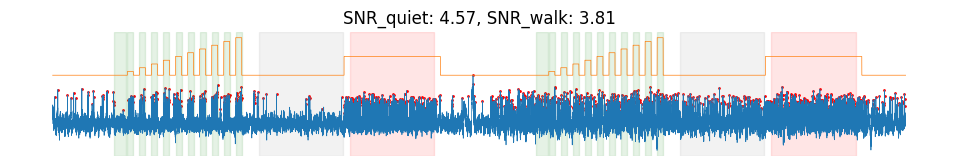

In [ ]:
# break the trace into two parts
trace1 = trace[:len(trace)//2]
trace2 = trace[len(trace)//2:]

pnorm1 = 0.5
pnorm2 = 0.5
spks1, tracefilt1, PTA1 = spike_detect(trace1, plot_templates=False, pnorm=pnorm1)
spks2, tracefilt2, PTA2 = spike_detect(trace2, plot_templates=False, pnorm=pnorm2)

# merge the two parts
tracefilt = np.concatenate((tracefilt1, tracefilt2))
spks = np.concatenate((spks1, spks2 + len(trace)//2))

FI_start_quiet = stim_start[:10]
FI_end_quiet = stim_end[:10]
FI_start_walk = stim_start[11:-1]
FI_end_walk = stim_end[11:-1]

FI_start_quiet = np.insert(FI_start_quiet, 0, stim_start[0]-1100)
FI_end_quiet = np.insert(FI_end_quiet, 0, stim_start[0]-100)
FI_start_walk = np.insert(FI_start_walk, 0, stim_start[11]-1100)
FI_end_walk = np.insert(FI_end_walk, 0, stim_start[11]-100)

DC_dur = 7000
spon_end_quiet = stim_start[10] - 100
spon_start_quiet = spon_end_quiet - DC_dur
spon_end_walk = stim_start[-1] - 100
spon_start_walk = spon_end_walk - DC_dur
DC_start_quiet = stim_start[10] + 500
DC_end_quiet = DC_start_quiet+DC_dur#stim_end[10] 
DC_start_walk = stim_start[-1] + 500
DC_end_walk = DC_start_walk+DC_dur#stim_end[-1]




plt.figure(figsize=(10, 2))
plt.plot(normalize(trace), linewidth=0.5)
# plot the spks
plt.scatter(spks, normalize(trace)[spks], c='r', s=1)
plt.plot(normalize(stim)/2+1, linewidth=0.5)

# indicate FI periods with shaded green areas
for i in range(len(FI_start_quiet)):
    plt.axvspan(FI_start_quiet[i], FI_end_quiet[i], color='green', alpha=0.1)
for i in range(len(FI_start_walk)):
    plt.axvspan(FI_start_walk[i], FI_end_walk[i], color='green', alpha=0.1)

# indicate DC periods with shaded red areas
plt.axvspan(DC_start_quiet, DC_end_quiet, color='red', alpha=0.1)
plt.axvspan(DC_start_walk, DC_end_walk, color='red', alpha=0.1)

# indicate spontaneous periods with shaded gray areas
plt.axvspan(spon_start_quiet, spon_end_quiet, color='gray', alpha=0.1)
plt.axvspan(spon_start_walk, spon_end_walk, color='gray', alpha=0.1)

SNR_quiet = snr(trace1, spks1)[0]
SNR_walk = snr(trace2, spks2)[0]

plt.title(f'SNR_quiet: {SNR_quiet:.2f}, SNR_walk: {SNR_walk:.2f}')

plt.tight_layout()

# remove axises
plt.axis('off')

plt.show()
